In [6]:
# For if you want to just be working in your cloned git directory, and not installed to a python environment
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline



In [22]:
params = {'QA_BITPACKED': False,
              'QA_FILL': 255,
              'QA_CLEAR': 0,
              'QA_WATER': 1,
              'QA_SHADOW': 2,
              'QA_SNOW': 3,
              'QA_CLOUD': 4}

In [4]:
import ccd
from notebooks.data_input import solution
#from test.shared import read_data
#data = read_data('/Users/arthur.platel/CCDC_again_copy/SC_sub_qa.csv') #test_3657_3610_observations.csv')
data = solution
dates, blues, greens, reds, nirs, ndvis, qas = data
results = ccd.detect(dates, blues, greens, reds, nirs, ndvis, qas, params=params)
print(data)

ModuleNotFoundError: No module named '_gdal'

Start Date: 2020-01-01 00:00:00
End Date: 2021-01-01 00:00:00

<class 'enumerate'>


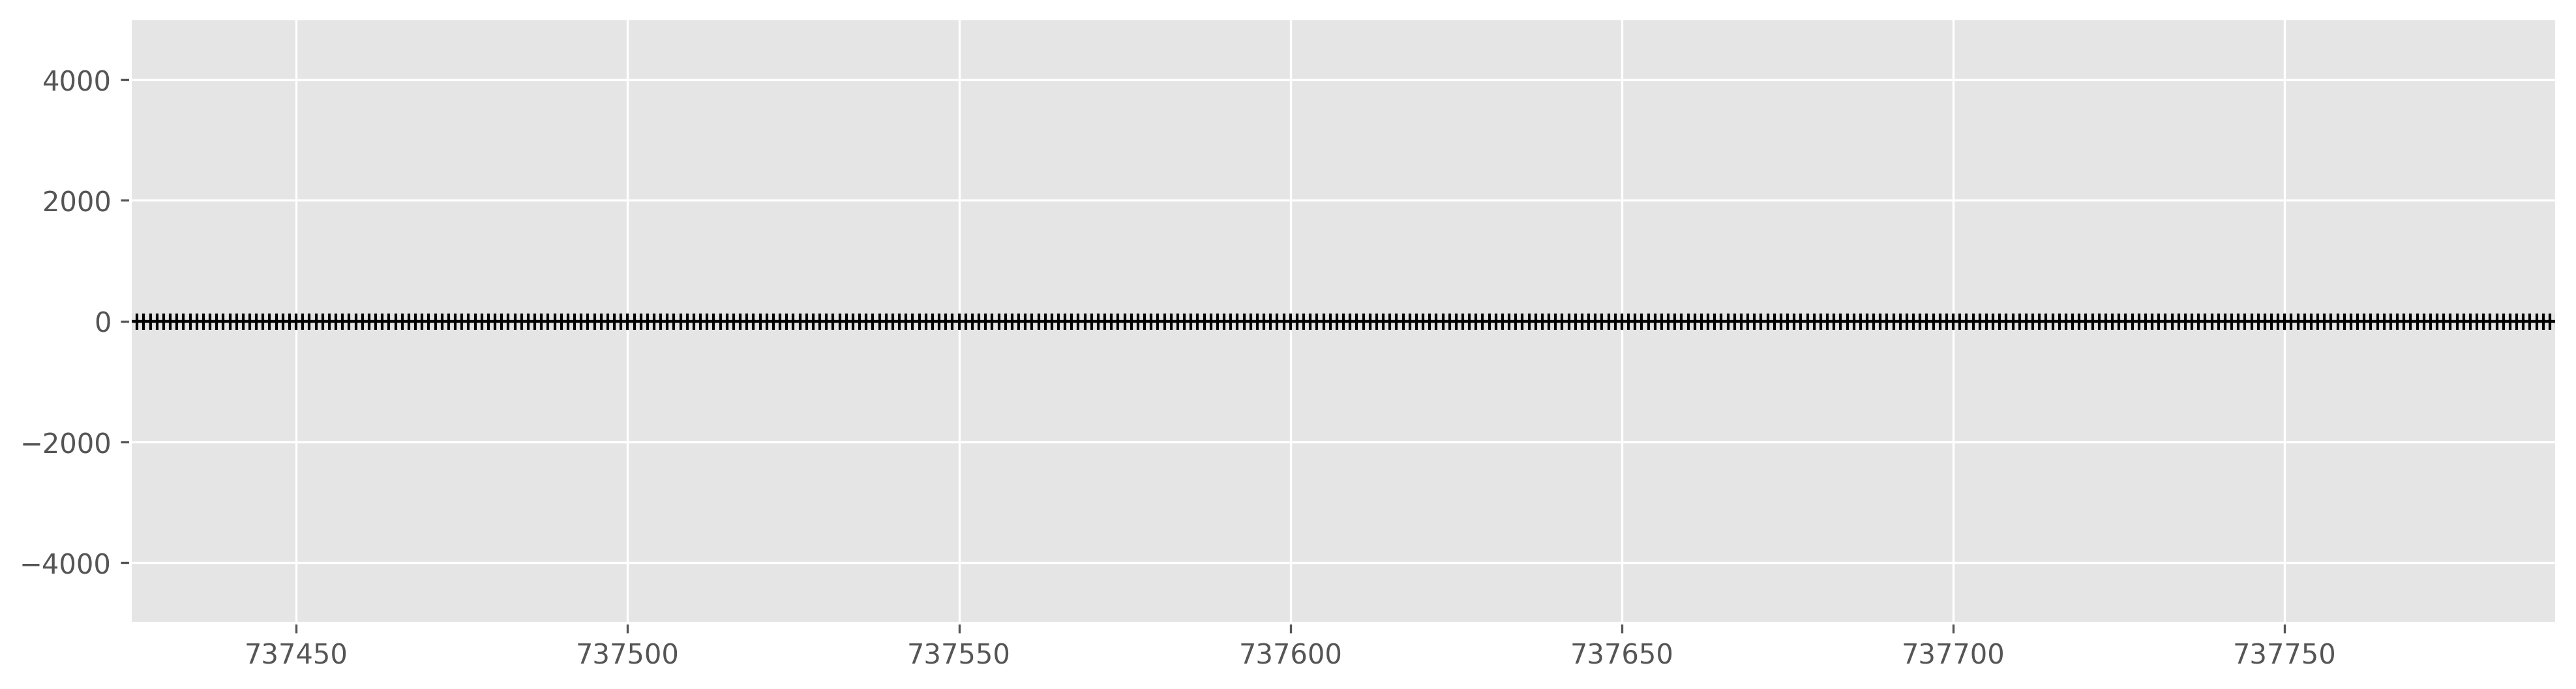

In [14]:
mask = np.array(results['processing_mask'], dtype=bool)
#print('Start Date: {0}\nEnd Date: {1}\n'.format(datetime.fromordinal(dates[0]),
 #                                               datetime.fromordinal(dates[-1])))
predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result['start_day'])))
    print('End Date: {}'.format(datetime.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(datetime.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Norm: {}\n'.format(np.linalg.norm([result['green']['magnitude'],
                                            result['red']['magnitude'],
                                            result['nir']['magnitude'],
                                            result['ndvi']['magnitude']])))
                                            #result['swir2']['magnitude']])))
   
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    prediction_dates.append(days)
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    
    intercept = result['green']['intercept']
    coef = result['green']['coefficients']
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-5000, 5000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], greens[mask], 'g+') # Observed values
a1.plot(dates[~mask], greens[~mask], 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)
for s in start_dates: a1.axvline(s, color='r')